## Setup for HISE usage

In [1]:
import hisepy
import os
import shutil

In [2]:
def read_path_uuid(file_uuid):
    file_path = '/home/jupyter/cache/{u}'.format(u = file_uuid)
    if not os.path.isdir(file_path):
        hise_res = hisepy.reader.cache_files([file_uuid])
    filename = os.listdir(file_path)[0]
    full_path = '{p}/{f}'.format(p = file_path, f = filename)
    return full_path

In [3]:
model_uuids = {
    'AIFI_L1': '482b9ec5-8631-48a1-a7ef-94e23fe97068',
    'AIFI_L2': 'cc78f20a-b962-4ddf-ae93-47d58741a644',
    'AIFI_L3': '671d1e43-bd32-4fea-bdda-d19a0484e664'
}

In [4]:
model_cache = {}
for name, uuid in model_uuids.items():
    model_cache[name] = read_path_uuid(uuid)

In [5]:
for loc in model_cache.values():
    shutil.copyfile(loc, os.path.basename(loc))

In [6]:
!pip install -q celltypist 

In [7]:
from urllib.request import urlretrieve

import celltypist
import scanpy as sc

## Load models

Import the CellTypist Healthy PBMC model for comparison:

In [8]:
celltypist.models.download_models(
    force_update = True,
    model = ['Healthy_COVID19_PBMC.pkl']
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 50
📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Healthy_COVID19_PBMC.pkl


Set locations of CellTypist models:

In [9]:
model_files = {
    'CellTypist_PBMC': 'Healthy_COVID19_PBMC.pkl',
    'AIFI_L1': 'ref_pbmc_clean_celltypist_model_AIFI_L1_2024-04-18.pkl',
    'AIFI_L2': 'ref_pbmc_clean_celltypist_model_AIFI_L2_2024-04-19.pkl',
    'AIFI_L3': 'ref_pbmc_clean_celltypist_model_AIFI_L3_2024-04-19.pkl'
}

## Download data from GEO

In [23]:
geo_url = ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5513397&format=file&file=GSM5513397%5FW4%2Dhashed%2D24k%5Fcount%2Dmatrix%2Eh5")
h5_filename = "GSM5513397_W4-hashed-24k_count-matrix.h5"
urlretrieve(geo_url, h5_filename)

('GSM5513397_W4-hashed-24k_count-matrix.h5',
 <http.client.HTTPMessage at 0x7f4d20651d80>)

## Read data using Scanpy

In [11]:
adata = sc.read_10x_h5(h5_filename)
adata

In [12]:
adata

AnnData object with n_obs × n_vars = 14478 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Normalize and log scale data for labeling:

In [13]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

## Predict labels for each model

In [14]:
label_results = {}

for model_name, model in model_files.items():
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'
    
    predictions = celltypist.annotate(
        adata, 
        model = model
    )
    
    labels = predictions.predicted_labels
    labels = labels.rename({'predicted_labels': label_column}, axis = 1)

    prob = predictions.probability_matrix
    prob_scores = []
    for i in range(labels.shape[0]):
        prob_scores.append(prob.loc[labels.index.to_list()[i],labels[label_column][i]])
    labels[score_column] = prob_scores

    label_results[model_name] = labels

🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3443 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 1099 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 1916 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 2483 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


## Summarize results for each model

In [26]:
for model_name, label_df in label_results.items():    
    label_column = f'{model_name}_prediction'
    label_summary = label_df[label_column].value_counts()
    print(label_summary, end = '\n\n')

CellTypist_PBMC_prediction
CD4.Naive                4661
CD14_mono                1976
CD8.Naive                1614
NK_16hi                  1184
CD4.IL22                  949
CD8.EM                    615
B_naive                   580
MAIT                      432
CD83_CD14_mono            387
gdT                       312
CD8.TE                    274
B_switched_memory         244
NK_56hi                   177
NKT                       148
B_immature                146
B_non-switched_memory     138
CD16_mono                 126
CD4.CM                    119
B_exhausted                81
DC3                        81
Plasma_cell_IgA            52
Plasma_cell_IgG            38
NK_prolif                  15
DC2                        13
CD4.Prolif                 13
C1_CD16_mono               12
Plasmablast                12
HSC_CD38pos                10
ASDC                        7
pDC                         7
CD4.Tfh                     6
CD4.Th1                     6
Platelets    

## Add model results to dataset

In [16]:
for model_name, label_df in label_results.items():    
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'

    adata.obs[label_column] = label_df[label_column]
    adata.obs[score_column] = label_df[score_column]

## Dimensionality reduction for visualization

In [17]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)

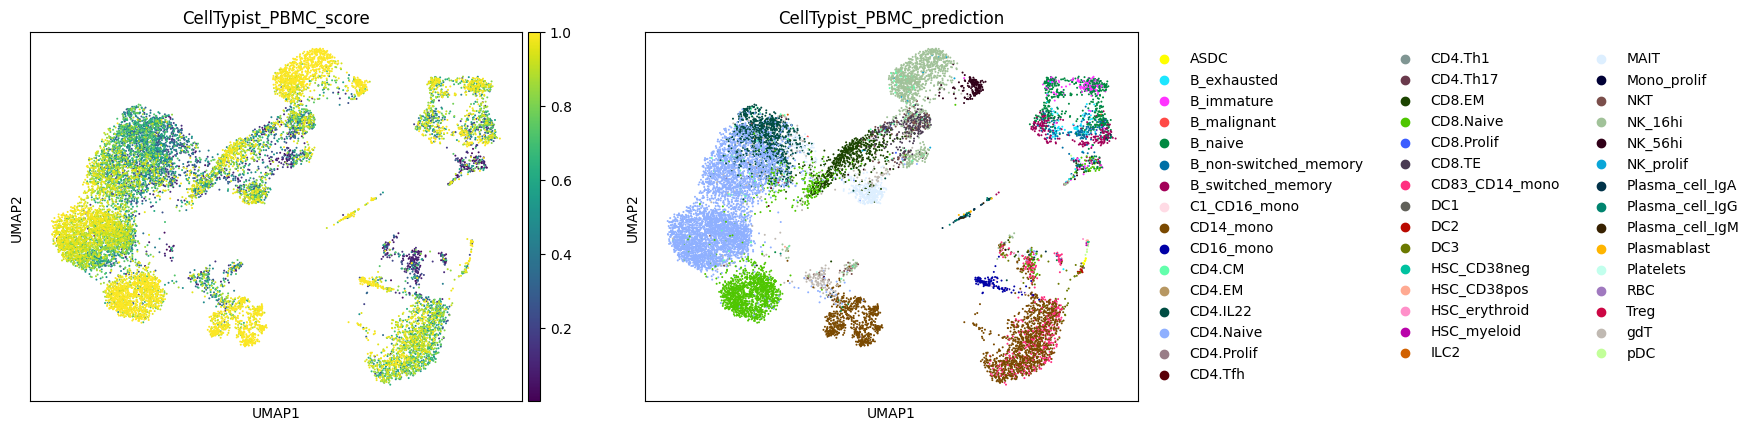

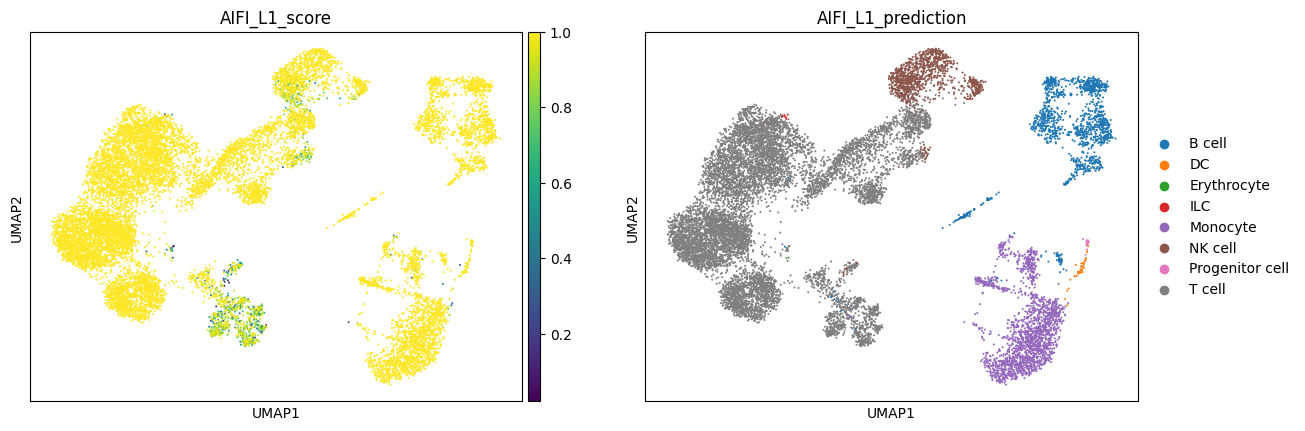

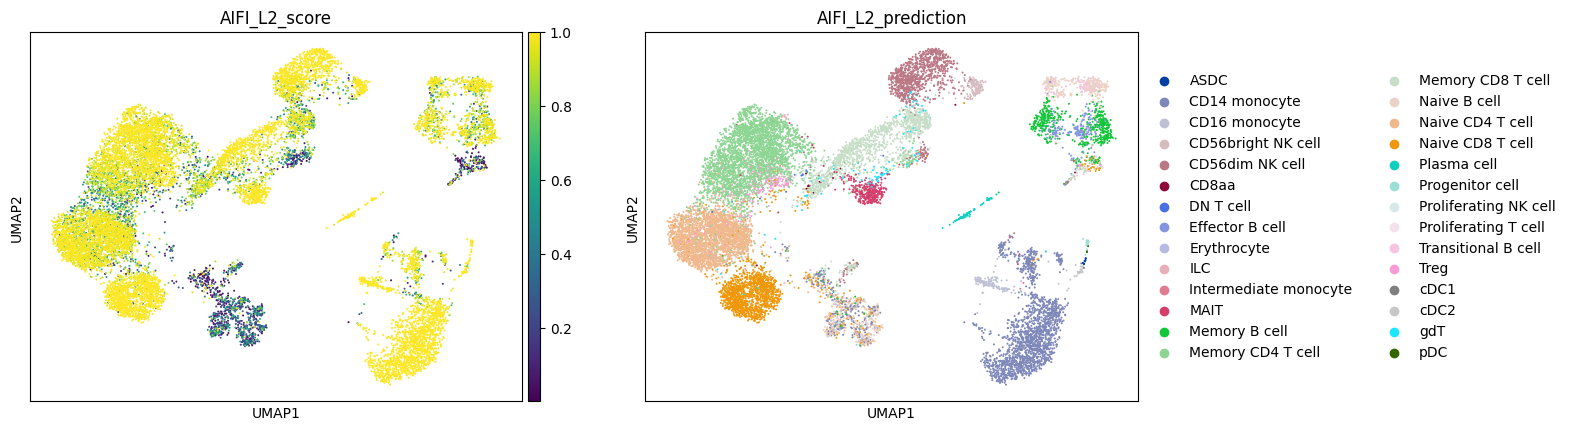

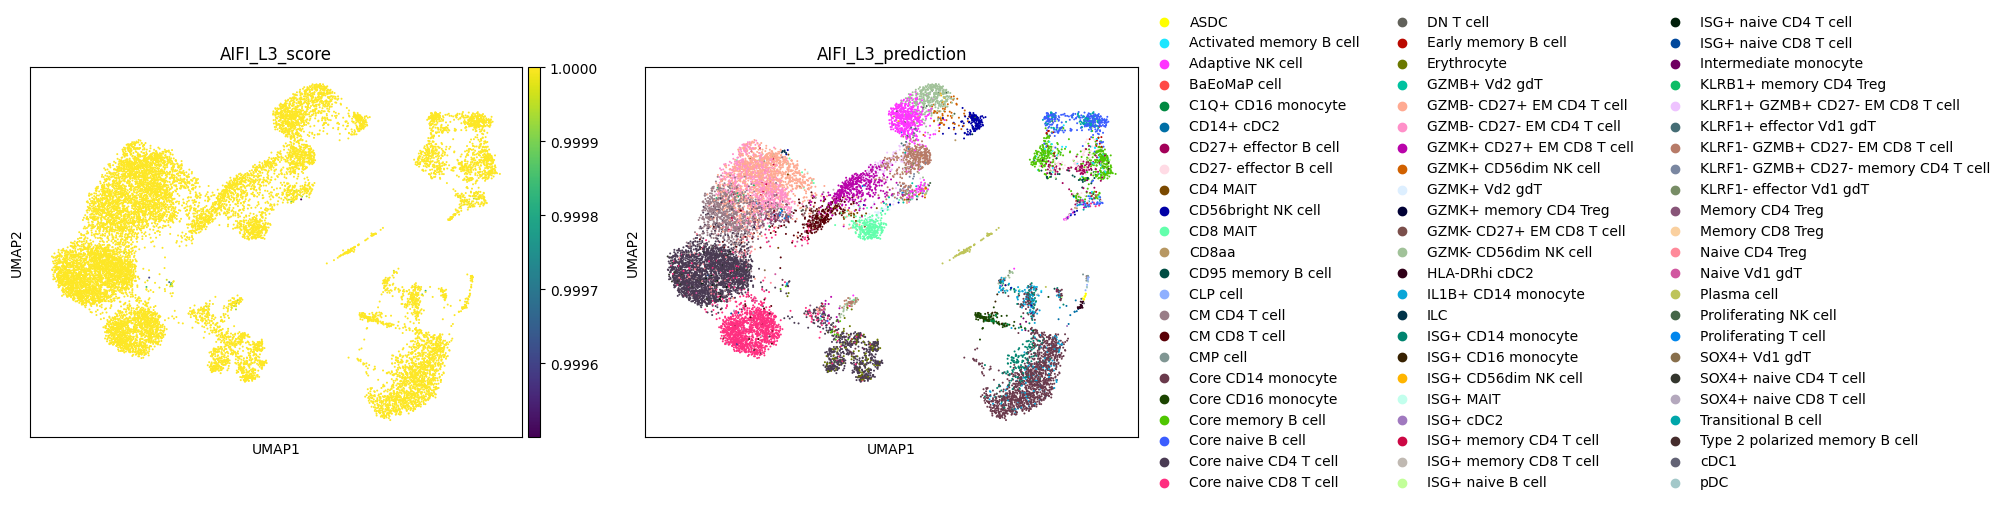

In [33]:
for model_name in label_results.keys():    
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'
    
    sc.pl.umap(
        adata,
        color = [score_column, label_column]
    )

## Save labeled data

In [19]:
adata.write_h5ad('labeled_GSM5513397_W4-hashed-24k_count-matrix.h5')

In [20]:
import session_info
session_info.show()